In [18]:
import re
import json
import glob
from collections import defaultdict
from datetime import datetime

import numpy as np
import h5py as h5
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

# from cellpose.models import CellposeModel 

from calmutils.misc.json import recursive_dict_query
from calmutils.stitching.transform_helpers import translation_matrix
from calmutils.stitching.fusion import fuse_image

def check_prescan(img, threshold=50, min_pixels_above=50):
    """
    simple boolean check whether more pixels than a minimum number have intensity above a threshold
    """
    return np.sum(img >= threshold) >= min_pixels_above


def get_autosted_measurement_times(h5file):

    res = defaultdict(list)

    with h5.File(h5file) as fd:
        experiment = fd['experiment']
        for k in experiment.keys():
            num_configs = experiment[k].attrs['num_configs']
            for config in range(num_configs):
                attrs = experiment[k][str(config)].attrs

                res['config'].append(config)
                res['dataset_idx'].append(k)
                res['run_start_time'].append(datetime.fromtimestamp(attrs['run_start_time']))
                res['run_end_time'].append(datetime.fromtimestamp(attrs['run_end_time']))
    return res

import pandas as pd
df = pd.DataFrame(get_autosted_measurement_times(files[1]))

df['level'] = df['dataset_idx'].apply(lambda s: re.findall('_?(.*?)_(\\d+)', s)[-1][0])
df['duration'] = df['run_end_time'] - df['run_start_time']

df.groupby('level')['duration'].mean()

level
pre_scan   0 days 00:00:00.814439740
Name: duration, dtype: timedelta64[ns]

In [3]:
file_path = '/scratch/hoerl/autosted/20251118_selective_overviews*/*.h5'

files = glob.glob(file_path)
files

['/scratch/hoerl/autosted/20251118_selective_overviews/307e5d10.h5',
 '/scratch/hoerl/autosted/20251118_selective_overviews_onlyprescan/a0e6d1c8.h5',
 '/scratch/hoerl/autosted/20251118_selective_overviews_onlyprescan/9dfcbf52.h5',
 '/scratch/hoerl/autosted/20251118_selective_overviews_onlyprescan/b78b0ce7.h5',
 '/scratch/hoerl/autosted/20251118_selective_overviews_onlyprescan/8052d15b.h5',
 '/scratch/hoerl/autosted/20251118_selective_overviews_onlyprescan/27c0025b.h5']

In [13]:
def process_file(file):

    images = []
    transforms = []

    with h5.File(file) as fd:
        experiment = fd['experiment']

        for k in experiment.keys():
            # split into [(level, idx), ... ]
            split_key = re.findall('_?(.*?)_(\\d+)', k)

            # only look at prescans
            if len(split_key) == 1:
                meta = json.loads(experiment[k]['0'].attrs['measurement_meta'])

                # load image data
                img = experiment[k]['0/0'][...]
                images.append(img.squeeze()[..., ::-1]) # NOTE: flip images (x-flipped data)

                # load stage position -> tranlation matrix
                pixel_size = np.array([recursive_dict_query(meta, f'ExpControl/scan/range/{d}/psz') for d in 'zyx'])
                stage_coords = np.array([recursive_dict_query(meta, f'ExpControl/scan/range/coarse_{d}/g_off') for d in 'zyx'])
                transforms.append(translation_matrix(stage_coords / pixel_size))

    # fuse all images in dataset
    fused_image = fuse_image(images, transforms)

    # do prescan check, count number of passing
    n_prescans_passed_i = sum([check_prescan(img) for img in images])

    return {
        "images": images, 
        "transforms": transforms,
        "fused_image": fused_image,
        "n_prescans_passed": n_prescans_passed_i
        }

results = {}

for file in files:
    results_i = process_file(file)
    results[file] = results_i
    print(f'{file} done.')

/scratch/hoerl/autosted/20251118_selective_overviews/307e5d10.h5 done.
/scratch/hoerl/autosted/20251118_selective_overviews_onlyprescan/a0e6d1c8.h5 done.
/scratch/hoerl/autosted/20251118_selective_overviews_onlyprescan/9dfcbf52.h5 done.
/scratch/hoerl/autosted/20251118_selective_overviews_onlyprescan/b78b0ce7.h5 done.
/scratch/hoerl/autosted/20251118_selective_overviews_onlyprescan/8052d15b.h5 done.
/scratch/hoerl/autosted/20251118_selective_overviews_onlyprescan/27c0025b.h5 done.


In [14]:
from scipy.ndimage import gaussian_filter
from skimage.filters import threshold_otsu, threshold_li
from skimage.morphology import label

for result in results.values():

    fused_image = result['fused_image']
    g = gaussian_filter(fused_image.max(axis=0).astype(float), 2)
    mask = label(g > threshold_otsu(g))

    result['n_cells'] = mask.max()
    result['mask'] = mask

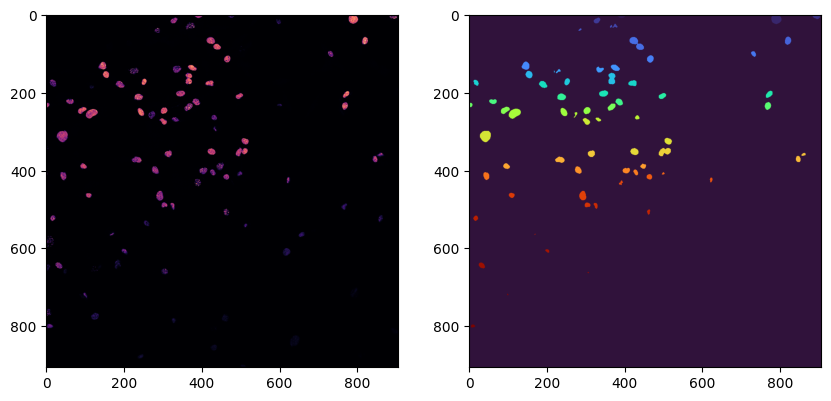

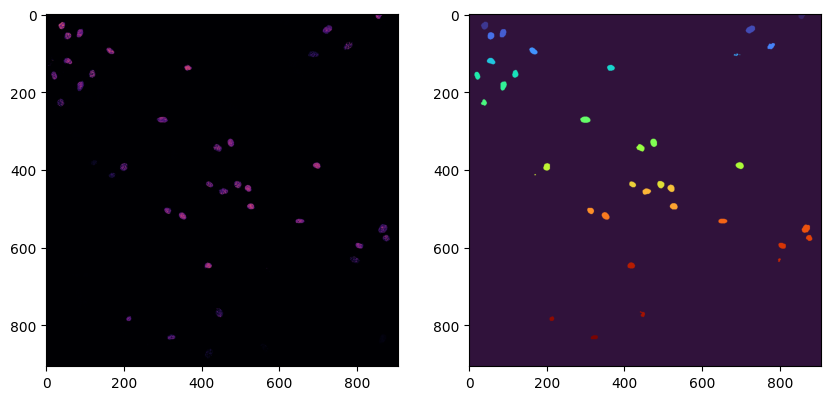

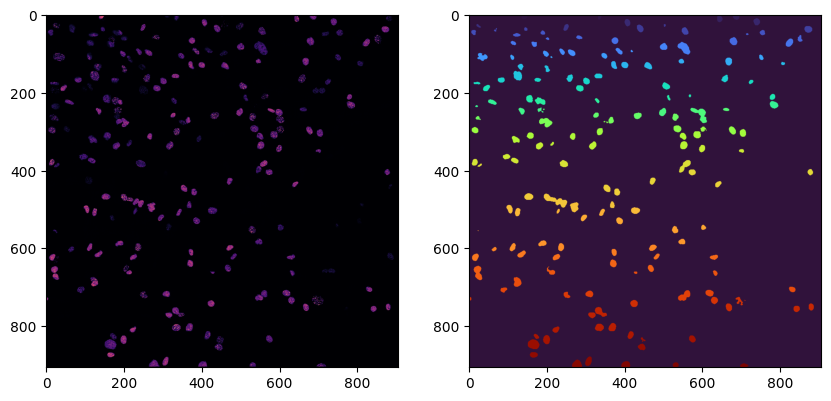

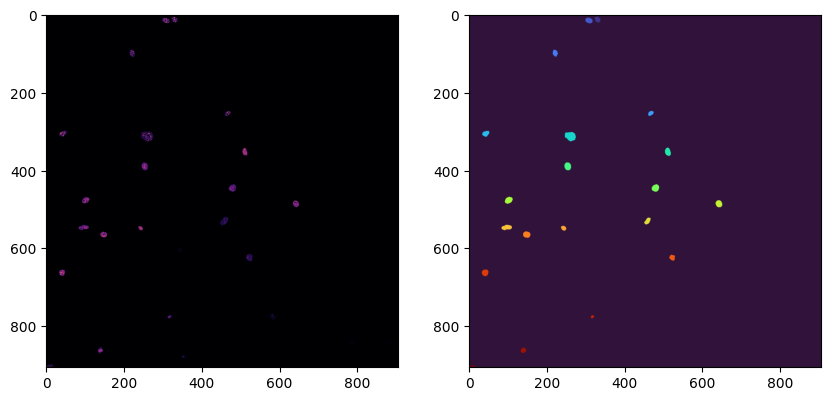

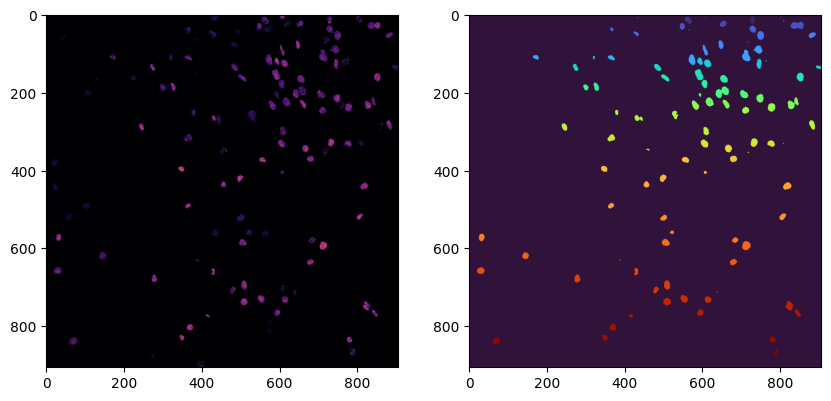

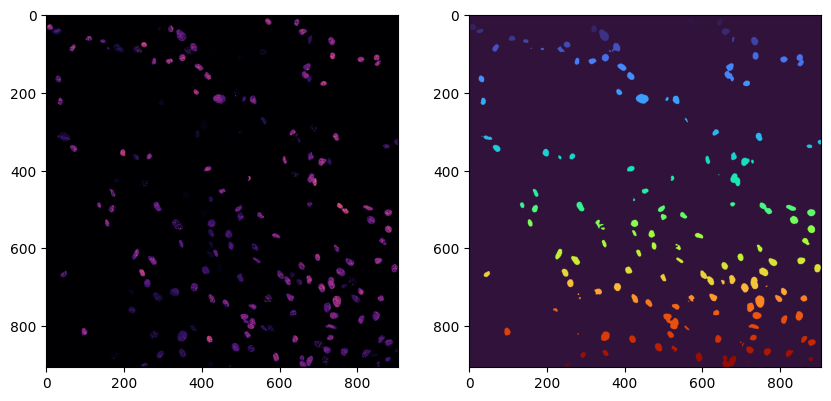

In [15]:

for result in results.values():

    fused_image = result['fused_image']
    mask = result['mask']

    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    axs[0].imshow(fused_image.max(axis=0), cmap='magma')
    axs[1].imshow(mask, cmap='turbo')

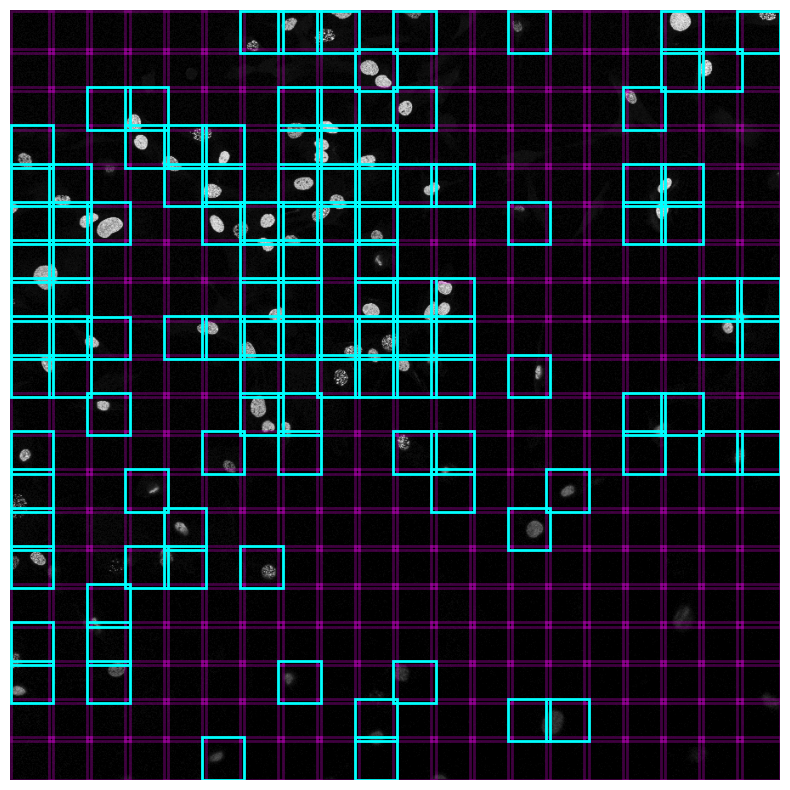

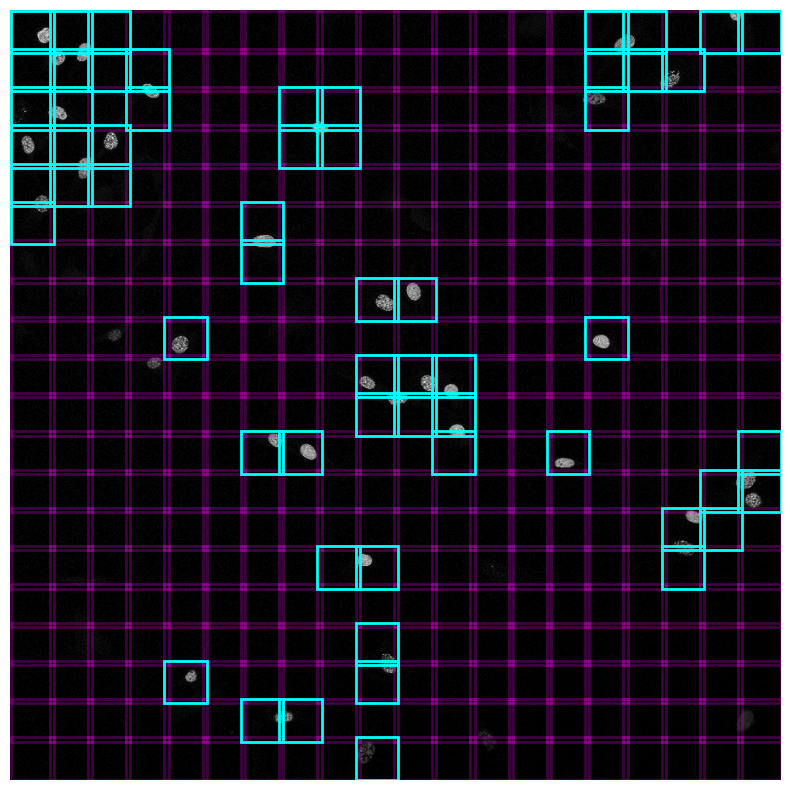

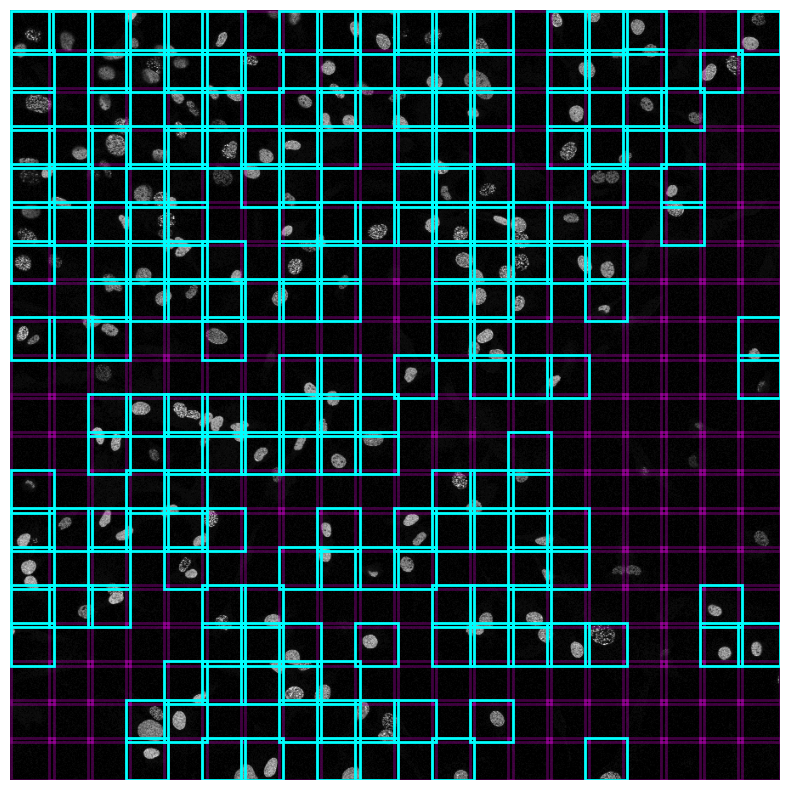

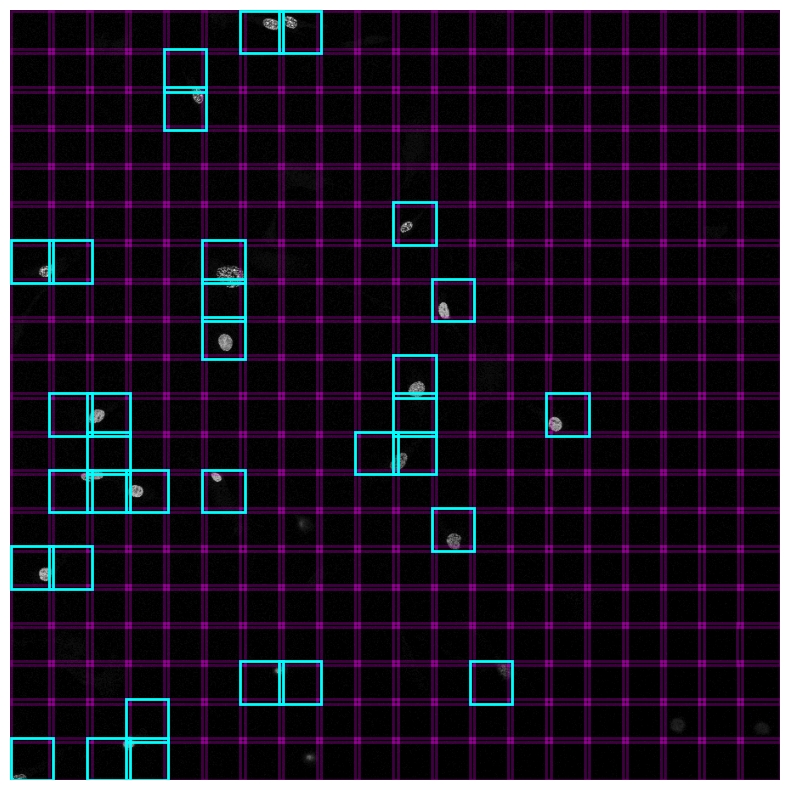

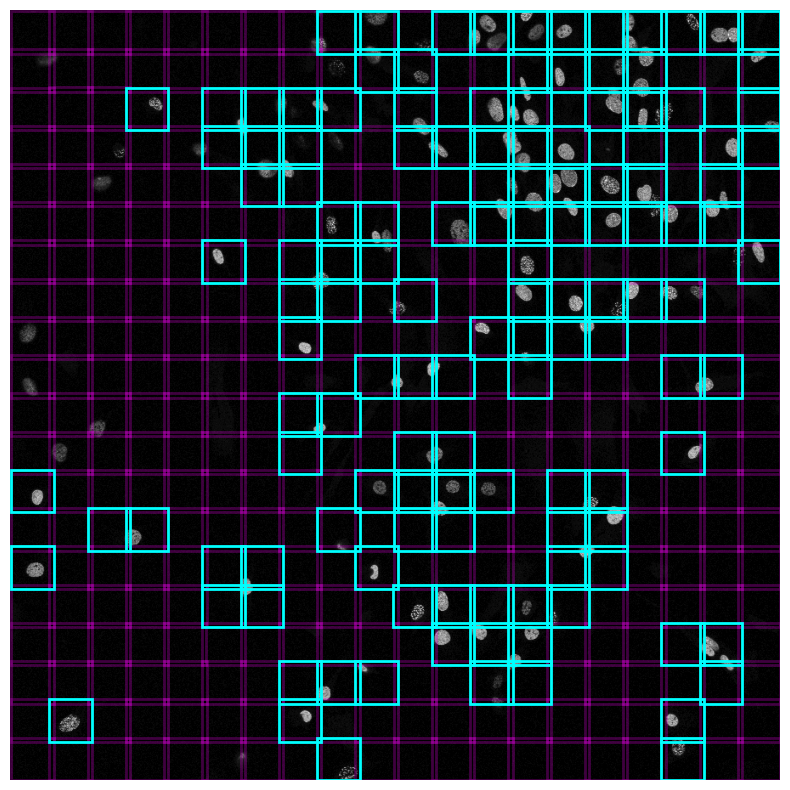

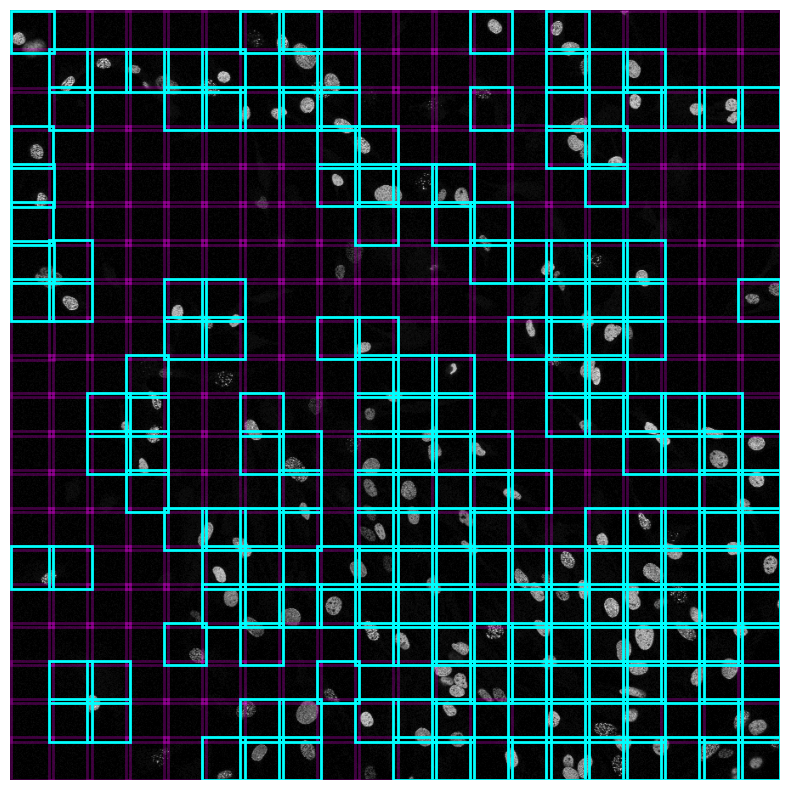

In [69]:
from calmutils.stitching.fusion.fusion import _get_default_bbox_for_fusion
from pathlib import Path

gamma = 1.8

for file, result in results.items():

    fused_image = result['fused_image']

    h,w = result['images'][0].shape[1:]


    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(fused_image.max(axis=0)**(1/gamma), cmap='gray')

    bbox = _get_default_bbox_for_fusion(result['images'], result['transforms'])
    minxy = np.array([bbox[2][0], bbox[1][0]])

    recs = []
    for img, transform in zip(result['images'], result['transforms']):
        xy = transform[1:-1,-1][::-1] - minxy

        # print(xy)
        good_tile = check_prescan(img, 50)
        color = 'cyan' if good_tile else 'magenta'
        zorder = 5 if good_tile else 4
        alpha = 1.0 if good_tile else 0.25

        recs.append(Rectangle(xy, w, h,color=color, fill=None, alpha=alpha, linewidth=2, zorder=zorder))


    ax.axis('off')

    for rec in recs:
        ax.add_artist(rec)



    outfile = f'pre_scan_tiles_{Path(file).stem}.svg'
    with plt.rc_context({'svg.fonttype': 'none'}):
        fig.savefig(outfile)


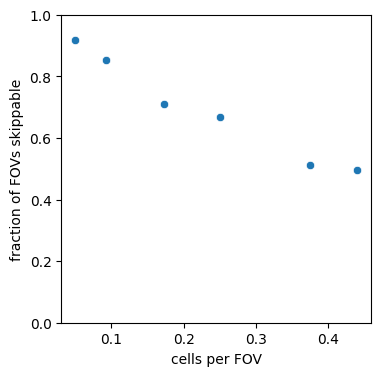

In [66]:
import seaborn as sns


x = np.array([r['n_cells'] for r in results.values()]) / 400
y = 1 - np.array([r['n_prescans_passed'] for r in results.values()]) / 400


plt.figure(figsize=(4,4))
sns.scatterplot(x=x, y=y)

plt.xlabel('cells per FOV')
plt.ylabel('fraction of FOVs skippable')
plt.ylim(0,1)

# n_cells, n_prescans_passed

with plt.rc_context({'svg.fonttype': 'none'}):
    plt.savefig('pre_scan.svg')